# DeepAR model to forecast stock price based on historical data

In [1]:
# Install dependencies (needed when opening the SageMaker notebook...)
#!pip install alpaca_trade_api

In [2]:
# General library imports here...
import os
import json
import datetime
import numpy as np
import pandas as pd
from path import Path
from dotenv import load_dotenv
from alpaca_trade_api.rest import REST, TimeFrame, TimeFrameUnit

# Amazon SageMaker imports here...
import boto3
import sagemaker
from DeepARPredictor import *
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import image_uris

%matplotlib inline
import matplotlib.pyplot as plt

### Load the environment variables (.env is a hidden file)

In [3]:
load_dotenv();

### Set the stock symbol, timeframe, and date range that will be used for modeling

In [4]:
symbol = "SPY"
interval = 15
frequency = f"{interval}min"
timeframe = TimeFrame(interval, TimeFrameUnit.Minute)

history = -30
timestamp = pd.Timestamp.now(tz="America/Phoenix").round(freq=frequency)
start_date = (timestamp+pd.Timedelta(days=history)).isoformat()
end_date = timestamp.isoformat()

# Used to filter the time range to be within normal market hours
market_open = pd.Timestamp("09:30:00", tz="America/Phoenix").time()
market_close = pd.Timestamp("16:00:00",tz="America/Phoenix").time()

### Functions to get the date window and historical data

In [5]:
def get_historical_data(symbol, timeframe, start=None, end=None, open=market_open, close=market_close, limit = 1000):
    
    alpaca_api_key = os.getenv("ALPACA_API_KEY")
    alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
    api = REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

    historical_data = api.get_barset(
        symbol,
        timeframe,
        start=start,
        end=end,
        limit=limit
    ).df[symbol]
    
    historical_data = historical_data.loc[(historical_data.index.time >= open) & (historical_data.index.time <= close)]
    historical_data.index = historical_data.index.tz_localize(None)
    return historical_data

### Fetch the historical data for the selected stock symbol, timeframe, and date range

In [6]:
historical_data = get_historical_data(symbol, timeframe, start_date, end_date)
historical_data = historical_data.loc[(historical_data.index.time >= market_open) & (historical_data.index.time <= market_close)]
historical_data.index = historical_data.index.tz_localize(None)

# Verify that the date and times are within the market hours
historical_data

,open,high,low,close,volume
time,,,,,
2021-11-11 09:30:00,465.230,465.280,464.250,464.610,50052
2021-11-11 09:45:00,464.610,465.125,464.595,464.990,35034
2021-11-11 10:00:00,465.030,465.030,464.325,464.580,50855
2021-11-11 10:15:00,464.635,464.680,464.260,464.340,18103
2021-11-11 10:30:00,464.240,464.680,463.945,464.590,30773
...,...,...,...,...,...
2021-12-10 15:00:00,468.660,469.050,468.390,468.980,34585
2021-12-10 15:15:00,468.980,469.560,468.890,469.455,27633
2021-12-10 15:30:00,469.455,470.000,469.455,470.000,46947


### Build the training dataset

In [7]:
# Context length for predictions
context_length = 16

# Number of prediction inferences
prediction_length = 3

# Build the training dataset
X_train = historical_data[:-prediction_length]

# Display the last 5 rows of the DataFrame
X_train.tail()

,open,high,low,close,volume
time,,,,,
2021-12-10 14:15:00,469.22,469.46,469.11,469.350,21714
2021-12-10 14:30:00,469.45,469.55,468.96,469.190,23173
2021-12-10 14:45:00,469.17,469.20,468.55,468.650,25359
2021-12-10 15:00:00,468.66,469.05,468.39,468.980,34585
2021-12-10 15:15:00,468.98,469.56,468.89,469.455,27633


### Build the test dataset (NOTE: it will include all data as recommended by the DeepAR Forecasting algorithm)

In [8]:
X_test = historical_data.copy()

# Display the last 5 rows of the DataFrame
X_test.tail()

,open,high,low,close,volume
time,,,,,
2021-12-10 15:00:00,468.660,469.05,468.390,468.980,34585
2021-12-10 15:15:00,468.980,469.56,468.890,469.455,27633
2021-12-10 15:30:00,469.455,470.00,469.455,470.000,46947
2021-12-10 15:45:00,470.030,470.88,470.030,470.690,226118
2021-12-10 16:00:00,470.590,470.75,470.570,470.750,5935


### Plot the training and test data

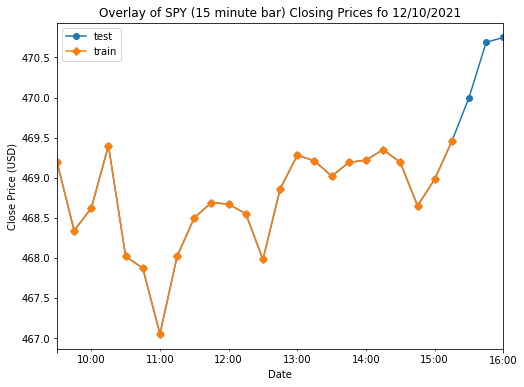

In [26]:
X_test[X_test.index.date[-1]:].close.plot(label="test", title="Overlay of SPY (15 minute bar) Closing Prices fo 12/10/2021", marker="o", legend=True, figsize=(8, 6))
X_train[X_train.index.date[-1]:].close.plot(label="train", xlabel="Date", ylabel="Close Price (USD)", legend=True, marker="D")
plt.show()

### Group the train and test by date to transform it to the time series format required by the DeepAR Algorithm (JSON Lines)

In [10]:
X_train_series = X_train.groupby(X_train.index.date)
X_test_series = X_test.groupby(X_test.index.date)

### Setup the Amazon Web Services cloud sessions and parameters

In [11]:
# Start the Amazon SageMaker session
sagemaker_session = sagemaker.Session()

# Set S3 Bucket to store model data
bucket = sagemaker_session.default_bucket()

# Set the Amazon Region name to use
region = boto3.Session().region_name

# Set prefix for data files
prefix = "stock-forecasting-deepar"

# Set the algorithm to be used
algorithm = "forecasting-deepar"

# Get the AWS execution role
role = get_execution_role()

# Get instance of S3 Client
s3 = boto3.client("s3")

# Set the S3 root app path
s3_root_path = f"s3://{bucket}/{prefix}"

# Set the S3 data path
s3_data_path = f"{s3_root_path}/data"

# Set the S3 output path
s3_output_path = f"{s3_root_path}/output"

# Set the S3 test data file path
s3_test_data_path = f"{s3_data_path}/test.json"

# Set the S3 train data filepath
s3_train_data_path = f"{s3_data_path}/train.json"

### Define the following functions to:
* Transform the data to the JSON Lines format
* Write out a binary file to local storage
* Create an http request for prediction
* Build a DataFrame from the response

In [12]:
def to_jsonline_format(start, targets):
    return {"start": str(start), "target": targets}

def write_binary_file(filename, series, encoding="utf-8"):
    with open(filename, "wb") as file:
        for group, data in series:
            file.write(f"{json.dumps(to_jsonline_format(data.index[0], list(data.close.values)))}\n".encode(encoding))
                       
def create_request(series, quantiles=["0.1", "0.5", "0.9"], encoding="utf-8"):
    instances = [to_jsonline_format(data.index[0], list(data.close.values)) for group, data in series]
    configuration = { "output_types": ["mean", "quantiles"], "quantiles": quantiles }
    request = { "instances": instances, "configuration": configuration }    
    return json.dumps(request).encode(encoding)

def build_dataframe_from_response(response, encoding="utf-8"):
    predictions_dict = json.loads(response.decode(encoding))['predictions'][-1]
    prediction_length = len(next(iter(predictions_dict['quantiles'].values())))
    prediction_means = pd.DataFrame(data=predictions_dict['mean'])
    prediction_quantiles = pd.DataFrame(data={**predictions_dict['quantiles']})
    predictions = pd.concat([prediction_means, prediction_quantiles], axis=1)
    predictions.columns = ["mean", "0.1", "0.5", "0.9"]
    return predictions

In [13]:
# JSON Line encode, write, and upload the train data
write_binary_file("train.json", X_train_series)
s3.upload_file("train.json", bucket, f"{prefix}/data/train.json")

# JSON Line encode, write, and upload the test data
write_binary_file("test.json", X_test_series)
s3.upload_file("test.json", bucket, f"{prefix}/data/test.json")

### Create the DeepAR model to be used for training

In [14]:
# Retrieve a container instance for the DeepAR forecasting algorithm
container = image_uris.retrieve(algorithm, region)

In [15]:
# Create an instance of the DeepAR forecasting estimator
estimator = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    sagemaker_session=sagemaker_session,
    output_path=s3_output_path
)

# Set the DeepAR forecasting hyperparameters
estimator.set_hyperparameters(
    epochs=40,
    num_cells=32,
    num_layers=3,
    dropout_rate=0.05,
    mini_batch_size=32,
    learning_rate=0.001,
    likelihood="gaussian",
    time_freq=frequency,
    early_stopping_patience=20,
    context_length=context_length,
    prediction_length=prediction_length
)

### Train the DeepAR model

In [16]:
estimator.fit({"train": s3_train_data_path, "test": s3_test_data_path})

2021-12-11 02:45:18 Starting - Starting the training job...
2021-12-11 02:45:41 Starting - Launching requested ML instancesProfilerReport-1639190718: InProgress
......
2021-12-11 02:46:42 Starting - Preparing the instances for training.........
2021-12-11 02:48:09 Downloading - Downloading input data...
2021-12-11 02:48:43 Training - Downloading the training image...
2021-12-11 02:49:09 Training - Training image download completed. Training in progress.Arguments: train
[12/11/2021 02:49:13 INFO 140183389099392] Reading default configuration from /opt/amazon/lib/python3.6/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihood': 'student-t', 'mini_batch_size': '128', 'num_cells': '40', 'num_dynamic_feat': 'auto', 'num_eval_samples': '100', 'num_la

### Deploy the SageMaker endpoint

In [18]:
deployment = estimator.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

--------!

### Make predictions and plot the results

In [19]:
deepar_predictor = DeepARPredictor(deployment.endpoint_name, sagemaker_session=sagemaker_session)
deepar_predictor.set_prediction_parameters(frequency, prediction_length)

In [20]:
predicted = deepar_predictor.predict(X_test_series)
actual = [data.close for group, data in X_test_series]

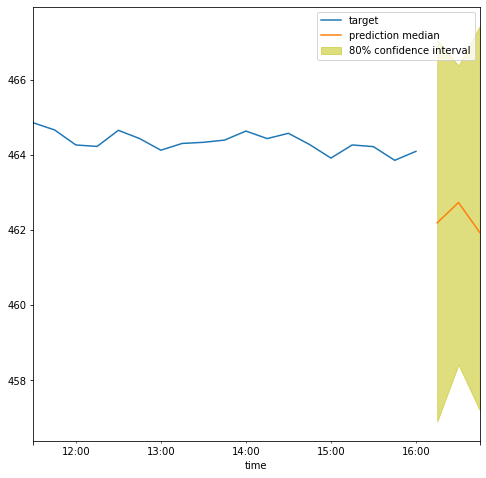

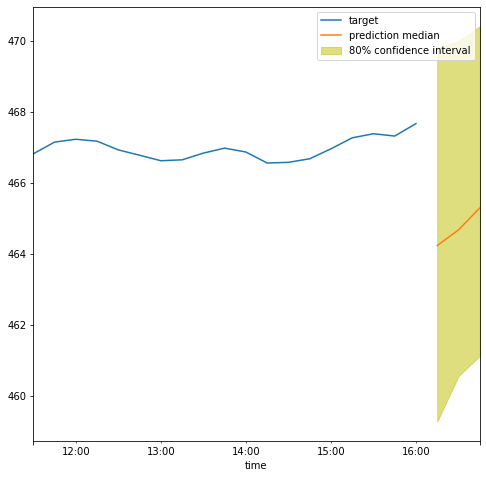

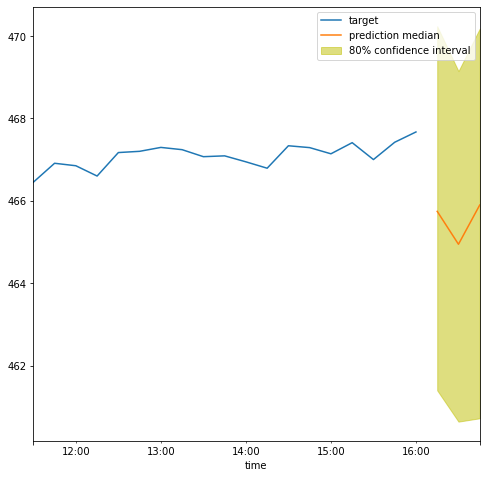

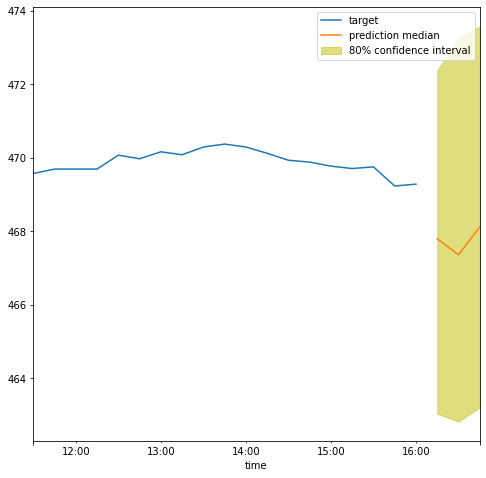

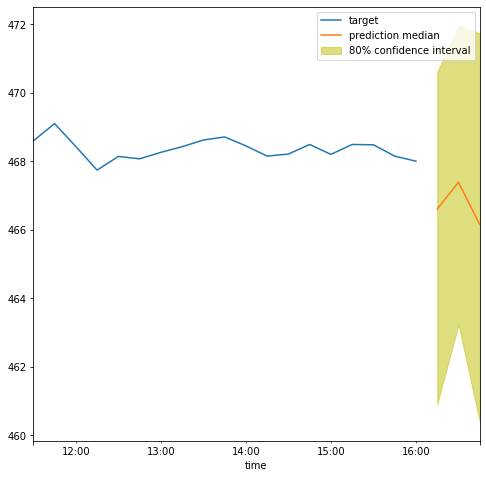

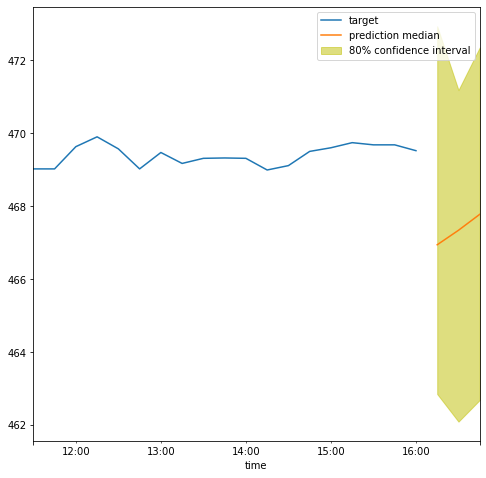

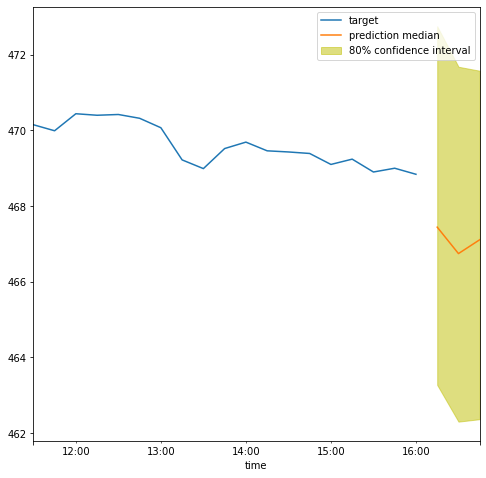

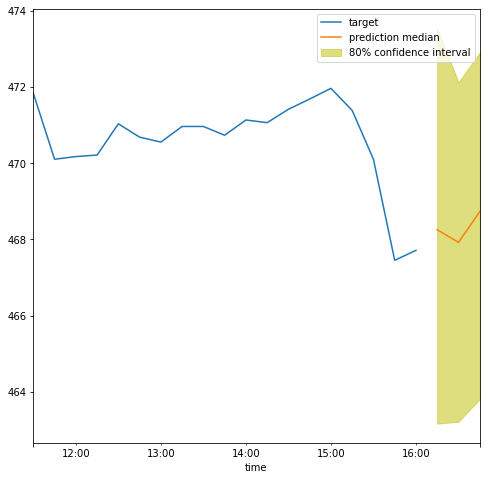

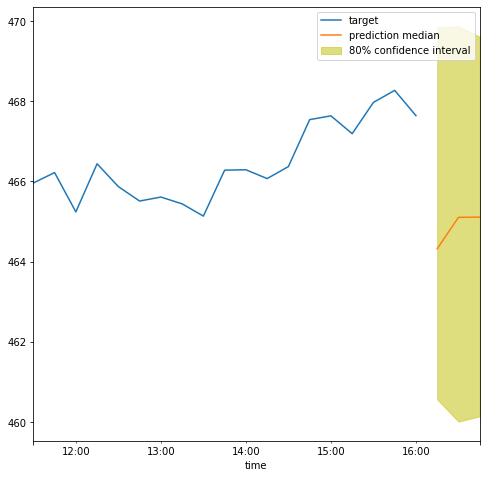

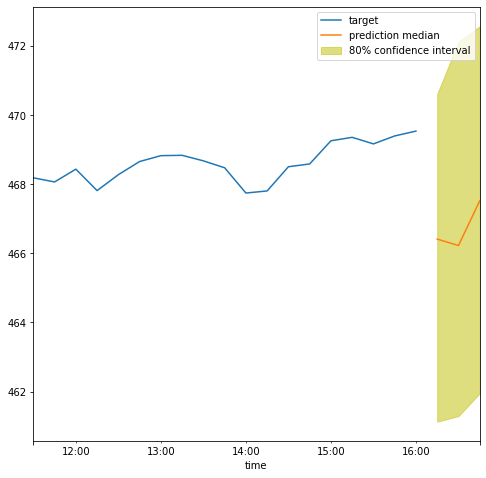

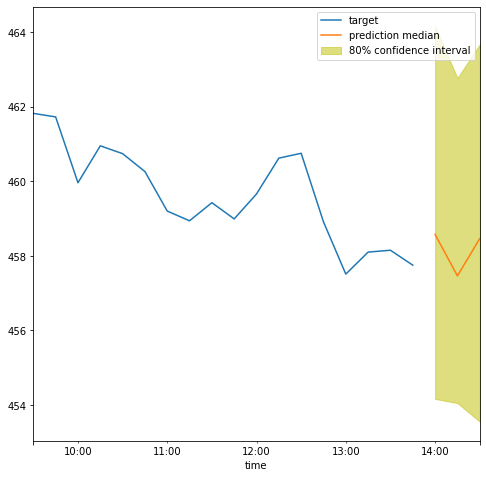

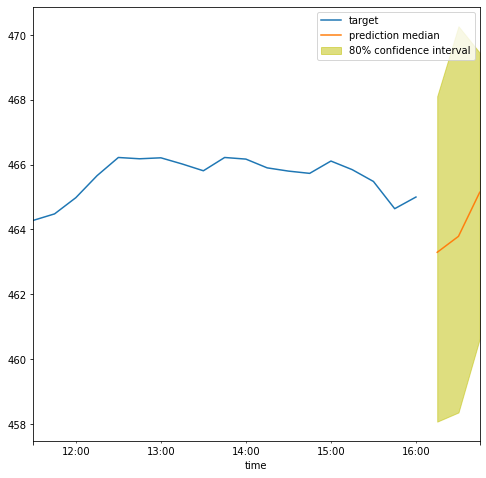

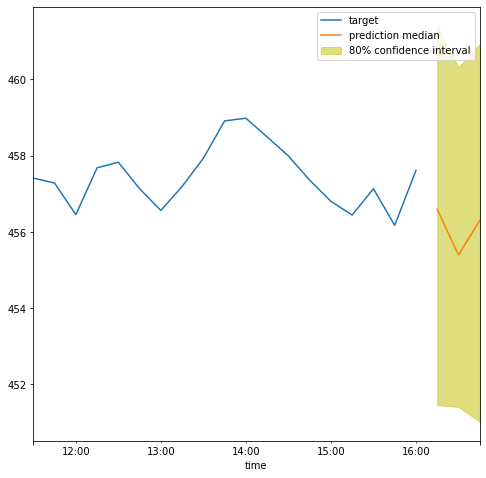

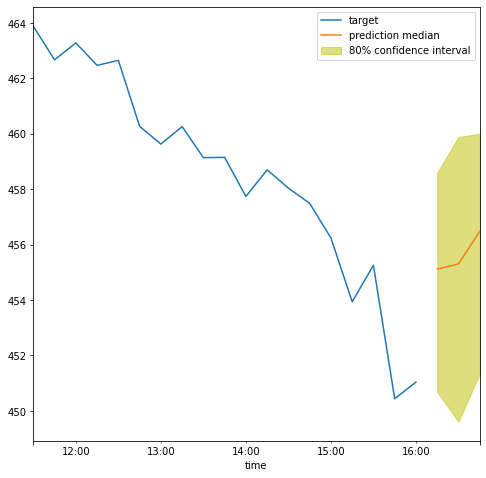

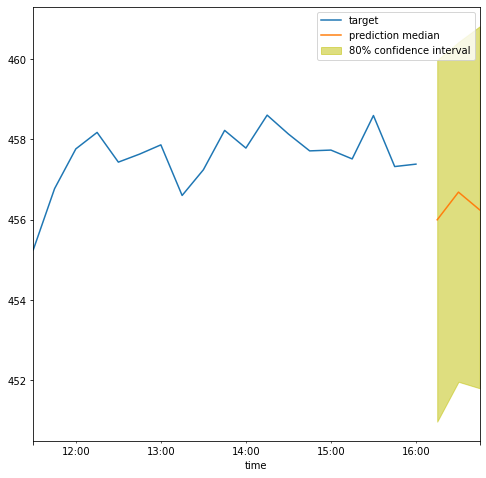

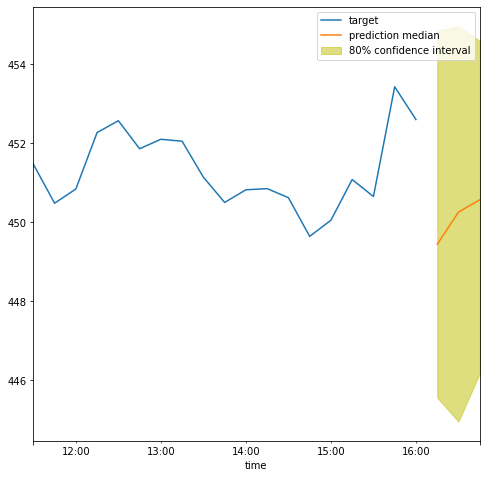

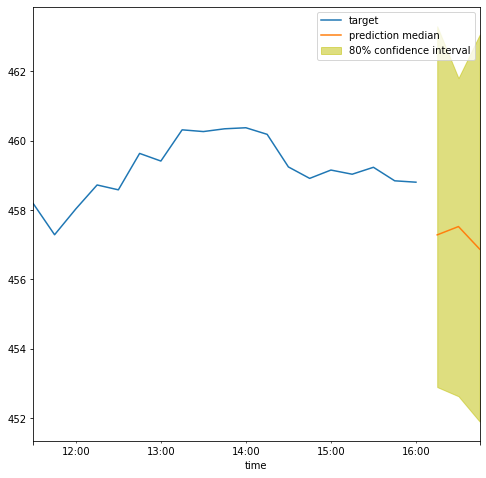

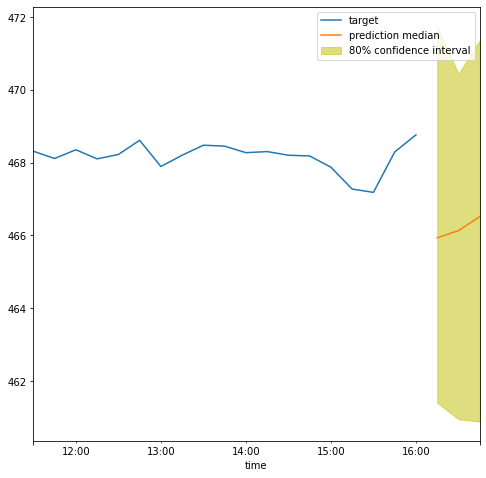

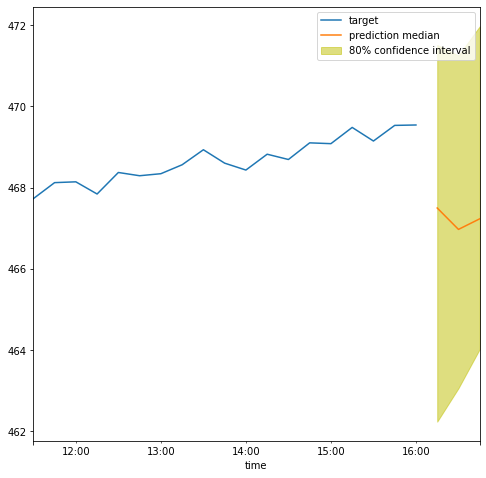

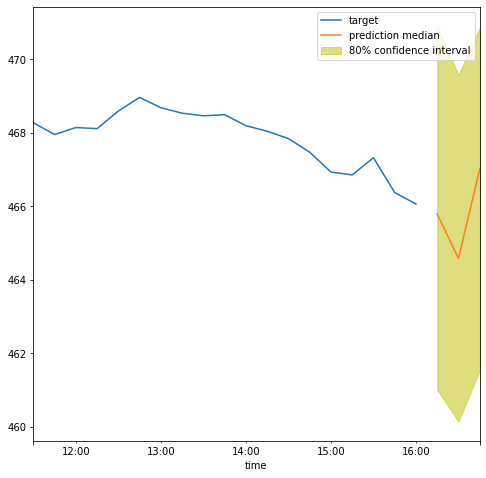

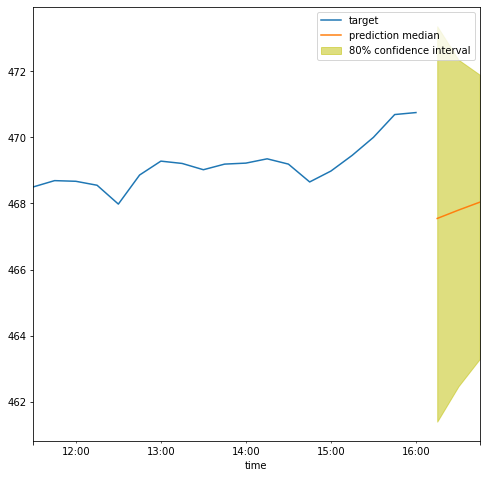

In [22]:
for index in range(len(predicted)):
    plt.figure(figsize=(8, 8))
    actual[index][-prediction_length - context_length :].plot(label="target")
    p10 = predicted[index]["0.1"]
    p90 = predicted[index]["0.9"]
    plt.fill_between(p10.index, p10, p90, color="y", alpha=0.5, label="80% confidence interval")
    predicted[index]["0.5"].plot(label="prediction median")
    plt.legend()
    plt.show()

### Delete the hosted endpoint

In [23]:
deployment.delete_endpoint()